## Training for H1 rapgap MC with reconstructed observables as input.
### This uses a single DNN with all inputs (electron, HFS, photons)


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [3]:
#has_gpu = False

has_gpu = True

training_name = 'training_h1_reg_v4b_tau1b_2'




#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9



learning_rate_setval_reg = 1e-5  
batch_size_setval = 1024
max_epochs = 5000
dropout_setval = 0.0
amsgrad_setval = True #####




#input_file = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file = 'MLAssistedUnfolding-files/all-h1-rapgap.root'
input_file = 'rapgap_ep0607_tau1b_2_test.root'


parfile = open( '%s-setup.txt' % training_name,'w')

parfile.write('%s\n' % datetime.now() )
parfile.write('training_name : %s\n' % training_name )
parfile.write('input_file : %s\n' % input_file )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )
parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )

parfile.close()

print('\n\n--- Training parameters file: %s-setup.txt\n' % training_name )
print( subprocess.getoutput('cat %s-setup.txt' % training_name ) )
print('\n\n')
    




--- Training parameters file: training_h1_reg_v4b_tau1b_2-setup.txt

2021-11-18 23:29:20.425370
training_name : training_h1_reg_v4b_tau1b_2
input_file : rapgap_ep0607_tau1b_2_test.root
max_events : 1000000000
learning_rate_setval_reg : 1e-05
batch_size_setval : 1024
max_epochs : 5000
dropout_setval : 0
amsgrad_setval : 1





In [4]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     #     'obs_x', 'obs_y', 'obs_Q2',
#     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_phi',  # 'obs_e_pz','obs_e_pt',
     'obs_e_theta',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
#     'obs_dphi',
     'obs_DeltaPhi',
     'obs_e_trk_e',
     # new minimal set of gen-level variables
     'beam_e_e','beam_p_e',
     'gen_HFS_Sigma', 'gen_HFS_T',
     'gen_eUncomb_E', 'gen_eUncomb_theta',
     'gen_eRecomb_E', 'gen_eRecomb_theta',
     # tau1b
     'gen_tau1b',
     'obs_tau1bs','obs_tau1be','obs_tau1bda',
     'obs_cHFSs_M','obs_cHFSs_pt','obs_cHFSs_theta','obs_cHFSs_phi',
    'obs_cHFSs_N',
     'obs_cHFSs_dRavg',
     'obs_cHFSs_dR2avg',
    'obs_cHFSs_Empz',
    'obs_cHFSs_Eppz' ,
    'obs_cHFSe_Empz',
    'obs_cHFSe_Eppz', 
    'obs_cHFSe_keE0',
    'obs_cHFSs_keE0',
    'obs_cHFSs_kesE0',
     # new minimal set of det-level variables 
     #'obs_e_e','obs_e_theta', 
     #'obs_hfs_T','obs_hfs_Sigma'ravg,
     # useful det-level quantities
    'wgt'
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f342ef54310>
wgt                        (no streamer)              asdtype('>f4')
gen_HFS_Sigma              (no streamer)              asdtype('>f4')
gen_HFS_T                  (no streamer)              asdtype('>f4')
gen_eUncomb_E              (no streamer)              asdtype('>f4')
gen_eUncomb_theta          (no streamer)              asdtype('>f4')
gen_eRecomb_E              (no streamer)              asdtype('>f4')
gen_eRecomb_theta          (no streamer)              asdtype('>f4')
obs_e_theta                (no streamer)              asdtype('>f4')
obs_DeltaPhi               (no streamer)              asdtype('>f4')
gen_tau1b                  (no streamer)              asdtype('>f4')
obs_tau1bs                 (no streamer)              asdtype('>f4')
obs_tau1bda                (no streamer)              asdtype('>f4')
obs_tau1bida               (no streamer)              asdtype('>f4')
obs_tau1be                 (no streamer)           

In [5]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_e_e,obs_e_phi,obs_e_theta,...,obs_cHFSs_N,obs_cHFSs_dRavg,obs_cHFSs_dR2avg,obs_cHFSs_Empz,obs_cHFSs_Eppz,obs_cHFSe_Empz,obs_cHFSe_Eppz,obs_cHFSe_keE0,obs_cHFSs_keE0,obs_cHFSs_kesE0
entry,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0,0,11.475868,1,-2.820129,3.237039,2.126804,11.475868,-2.463482,2.295296,...,1.121039e-44,0.965368,1.161897,13.753245,0.182402,13.753245,0.182402,1.983880,0.0,1.041491
2,0,0,12.831685,2,0.005041,0.146400,-2.105477,12.669315,0.740783,1.662968,...,1.541428e-44,0.248228,0.097798,44.304184,10.433638,44.304184,10.433638,38.516136,0.0,16.467018
3,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0,0,20.209551,1,-0.311222,8.581358,2.943829,20.209551,-0.256977,2.258258,...,1.121039e-44,0.427105,0.294857,25.641750,14.336704,25.641750,14.336704,44.691914,0.0,20.683670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993286,0,0,18.550781,1,-0.480112,3.029652,-0.600688,18.550781,2.967890,2.401874,...,8.407791e-45,0.403272,0.223033,12.671455,7.471155,12.464856,6.946755,18.732681,0.0,10.990106
993287,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
993288,0,0,40.384975,1,0.616091,0.261239,-0.583183,40.384975,-2.863837,1.805451,...,2.942727e-44,0.621430,0.663458,4.303556,181.340637,4.329085,184.865021,408.114746,0.0,199.867203


In [8]:
## tau1b: to be cleaned up

# rename input quantites (temporarily)
#pandas_df.eval( 'obs_e_E         = obs_e_e', inplace=True )
pandas_df.eval( 'obs_e_pz  = obs_e_e*cos(obs_e_theta)', inplace=True )
pandas_df.eval( 'obs_e_pt  = obs_e_e*sin(obs_e_theta)', inplace=True )
#pandas_df.eval( 'obs_e_theta   = arcsin(obs_e_pt/obs_e_E)', inplace=True )
pandas_df.eval( 'obs_hfs_Sigma = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_hfs_T     = obs_hfs_pt', inplace=True )

# useful derived quantites
pandas_df.eval( 'obs_e_Sigma      = obs_e_e - obs_e_pz', inplace=True )
#pandas_df.eval( 'obs_e_tantheta   = sin(obs_e_theta/2.)/cos(obs_e_theta/2.)', inplace=True )
pandas_df.eval( 'obs_e_tantheta   = obs_e_Sigma/obs_e_pt', inplace=True )
pandas_df.eval( 'obs_e_Pt2        = obs_e_pt*obs_e_pt', inplace=True )
pandas_df.eval( 'obs_hfs_tangamma = obs_hfs_Sigma/obs_hfs_pt', inplace=True )

###########################################################
### DIS-DNN originals
###########################################################
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

###########################################################

# inelasticity
pandas_df.eval( 'obs_kine_ye   = 1. - obs_e_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'obs_kine_yda  = obs_hfs_tangamma/(obs_hfs_tangamma+obs_e_tantheta)', inplace=True )
pandas_df.eval( 'obs_kine_yh   = obs_hfs_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'obs_kine_ys   = obs_hfs_Sigma/(obs_hfs_Sigma+obs_e_Sigma)', inplace=True )
#pandas_df.eval( 'obs_kine_yes  = 2.*beam_e_e*obs_hfs_Sigma/(obs_hfs_Sigma+obs_e_Sigma)/(obs_hfs_Sigma+obs_e_Sigma)', inplace=True )

# Q2
pandas_df.eval( 'obs_kine_Q2e   = obs_e_Pt2/(1.-obs_kine_ye)', inplace=True )
pandas_df.eval( 'obs_kine_Q2da  = 4.*beam_e_e*beam_e_e/obs_e_tantheta/(obs_hfs_tangamma+obs_e_tantheta)', inplace=True )
pandas_df.eval( 'obs_kine_Q2s   = obs_e_Pt2/(1.-obs_kine_ys)', inplace=True )
pandas_df.eval( 'obs_kine_Q2ida = obs_e_Pt2/(1.-obs_kine_yda)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2h   = obs_hfs_T*obs_hfs_T/(1.-obs_kine_yh)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2ees = 2.*beam_e_e*(2.*obs_e_e - 2.*beam_e_e + obs_hfs_Sigma)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2ets = 2.*beam_e_e*(2.*beam_e_e - obs_hfs_Sigma) / obs_e_tantheta/obs_e_tantheta', inplace=True )
#pandas_df.eval( 'obs_kine_Q2tsg = obs_hfs_T*obs_hfs_T/(1.-obs_kine_yda) ', inplace=True )
##pandas_df.eval( 'obs_kine_Q2tsg = obs_hfs_Sigma*obs_hfs_Sigma/(obs_hfs_tangamma*obs_hfs_tangamma)/(1.-obs_kine_yda) ', inplace=True )

# x
#pandas_df.eval( 'obs_kine_xe   = 1./beam_p_e * obs_kine_Q2e   /4. /beam_e_e/obs_kine_ye', inplace=True )
#pandas_df.eval( 'obs_kine_xees = 1./beam_p_e * obs_kine_Q2ees /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xets = 1./beam_p_e * obs_kine_Q2ets /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xda  = 1./beam_p_e * obs_kine_Q2da  /4. /beam_e_e/obs_kine_yda', inplace=True )
#pandas_df.eval( 'obs_kine_xh   = 1./beam_p_e * obs_kine_Q2h   /2. /obs_hfs_Sigma', inplace=True )
pandas_df.eval( 'obs_kine_xis  = 1./beam_p_e * obs_kine_Q2s   /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xida = 1./beam_p_e * obs_e_e * (1+cos(obs_e_theta))/2./obs_kine_yda', inplace=True ) #check, if theta is correct?!
#pandas_df.eval( 'obs_kine_xtsg = 1./beam_p_e * obs_kine_Q2tsg /2. /obs_hfs_Sigma', inplace=True )



In [11]:
# gen level DIS-DNN originals 
#pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
#pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
#pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )


# useful derived quantites
pandas_df.eval( 'gen_e_Sigma      = gen_eRecomb_E * (1. - cos(gen_eRecomb_theta))', inplace=True )
pandas_df.eval( 'gen_e_tantheta   = sin(gen_eRecomb_theta/2.)/cos(gen_eRecomb_theta/2.)', inplace=True )
pandas_df.eval( 'gen_e_Pt2        = gen_eRecomb_E*gen_eRecomb_E * sin(gen_eRecomb_theta)* sin(gen_eRecomb_theta)', inplace=True )
pandas_df.eval( 'gen_HFS_tangamma = gen_HFS_Sigma/gen_HFS_T', inplace=True )

# inelasticity
pandas_df.eval( 'gen_kine_ye   = 1. - gen_e_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'gen_kine_yda  = gen_HFS_tangamma/(gen_HFS_tangamma+gen_e_tantheta)', inplace=True )
pandas_df.eval( 'gen_kine_ys   = gen_HFS_Sigma/(gen_HFS_Sigma+gen_e_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_yes  = 2.*beam_e_e*gen_HFS_Sigma/(gen_HFS_Sigma+gen_e_Sigma)/(gen_HFS_Sigma+gen_e_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_yh   = gen_HFS_Sigma/2./beam_e_e', inplace=True )

# Q2
pandas_df.eval( 'gen_kine_Q2e   = gen_e_Pt2/(1.-gen_kine_ye)', inplace=True )
pandas_df.eval( 'gen_kine_Q2da  = 4.*beam_e_e*beam_e_e/gen_e_tantheta/(gen_HFS_tangamma+gen_e_tantheta)', inplace=True )
pandas_df.eval( 'gen_kine_Q2s   = gen_e_Pt2/(1.-gen_kine_ys)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2h   = gen_HFS_T*gen_HFS_T/(1.-gen_kine_yh)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ida = gen_e_Pt2/(1.-gen_kine_yda)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ees = 2.*beam_e_e*(2.*gen_eRecomb_E - 2.*beam_e_e + gen_HFS_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ets = 2.*beam_e_e*(2.*beam_e_e - gen_HFS_Sigma) / gen_e_tantheta/gen_e_tantheta', inplace=True )
#pandas_df.eval( 'gen_kine_Q2tsg = gen_HFS_T*gen_HFS_T/(1.-gen_kine_yda) ', inplace=True )
##pandas_df.eval( 'gen_kine_Q2tsg = gen_HFS_Sigma*gen_HFS_Sigma/(gen_HFS_tangamma*gen_HFS_tangamma)/(1.-gen_kine_yda) ', inplace=True )

# x
#pandas_df.eval( 'gen_kine_xe   = 1./beam_p_e * gen_kine_Q2e   /4. /beam_e_e/gen_kine_ye', inplace=True )
#pandas_df.eval( 'gen_kine_xees = 1./beam_p_e * gen_kine_Q2ees /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xets = 1./beam_p_e * gen_kine_Q2ets /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xda  = 1./beam_p_e * gen_kine_Q2da  /4. /beam_e_e/gen_kine_yda', inplace=True )
#pandas_df.eval( 'gen_kine_xh   = 1./beam_p_e * gen_kine_Q2h   /2. /gen_HFS_Sigma', inplace=True )
pandas_df.eval( 'gen_kine_xis  = 1./beam_p_e * gen_kine_Q2s   /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xida = 1./beam_p_e * gen_eRecomb_E * (1+cos(gen_eRecomb_theta))/2./gen_kine_yda', inplace=True )
#pandas_df.eval( 'gen_kine_xtsg = 1./beam_p_e * gen_kine_Q2tsg /2. /gen_HFS_Sigma', inplace=True )

# target variables
pandas_df.eval( 'gen_log_x  = log(gen_kine_xis)', inplace=True )
pandas_df.eval( 'gen_log_y  = log(gen_kine_ys)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(gen_kine_Q2s)', inplace=True )


In [12]:


pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



## Apply any event selection here.

In [17]:
pandas_df = pandas_df.query('obs_event_Empz > 0')

pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

pandas_df = pandas_df.query('gen_kine_Q2s > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )



 Number of entries in pandas_df:  198588 


In [18]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_e_e,obs_e_phi,obs_e_theta,...,gen_kine_ys,gen_kine_Q2e,gen_kine_Q2da,gen_kine_Q2s,gen_kine_xis,gen_log_x,gen_log_y,gen_log_Q2,obs_ptbal,obs_pzbal
entry,,,,,,,,,,,,,,,,,,,,,
4,0,0,20.209551,1,-0.311222,8.581358,2.943829,20.209551,-0.256977,2.258258,...,0.419577,398.057526,398.054382,398.060608,0.009341,-4.673379,-0.868508,5.986604,0.169986,-0.080367
5,0,0,15.397686,1,-0.377754,0.290717,-2.572304,15.397686,0.548327,2.385688,...,0.518111,232.726349,232.724518,232.728134,0.004422,-5.421056,-0.657565,5.449871,-0.002269,0.017671
10,0,0,29.740814,1,0.729032,0.956096,-1.160265,29.740814,1.770594,2.120421,...,0.168248,793.586121,793.579529,793.592834,0.046440,-3.069605,-1.782318,6.676570,0.045131,0.015264
21,0,0,38.133362,1,1.249641,1.029780,-2.173697,38.133362,1.651331,1.090442,...,0.634621,3025.722656,3025.696289,3025.748291,0.046942,-3.058852,-0.454728,8.014914,0.105949,-0.077938
28,0,0,29.436708,1,0.572823,0.301733,2.521725,29.436708,-0.542823,2.363105,...,0.111034,454.213684,454.209747,454.217651,0.040276,-3.212001,-2.197916,6.118577,0.096657,-0.050702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993276,1,0,21.169916,1,-0.532020,0.291703,2.625344,21.169916,2.778541,2.525410,...,0.272766,214.907669,219.924530,210.004959,0.007757,-4.859135,-1.299141,5.347131,0.278412,0.037706
993278,0,0,16.624249,1,0.015031,8.395049,0.529148,16.624249,-2.276433,2.229625,...,0.511850,355.849915,355.846893,355.852875,0.006845,-4.984251,-0.669724,5.874517,-0.636381,0.121723
993282,0,0,15.445232,1,-0.506523,0.586267,-0.957350,15.445232,-2.389302,2.298164,...,0.515267,294.972168,294.969482,294.974884,0.005636,-5.178533,-0.663070,5.686890,-0.158483,0.123751


array([[<AxesSubplot:title={'center':'gen_log_x'}>,
        <AxesSubplot:title={'center':'gen_log_y'}>],
       [<AxesSubplot:title={'center':'gen_log_Q2'}>,
        <AxesSubplot:title={'center':'obs_event_Empz'}>]], dtype=object)

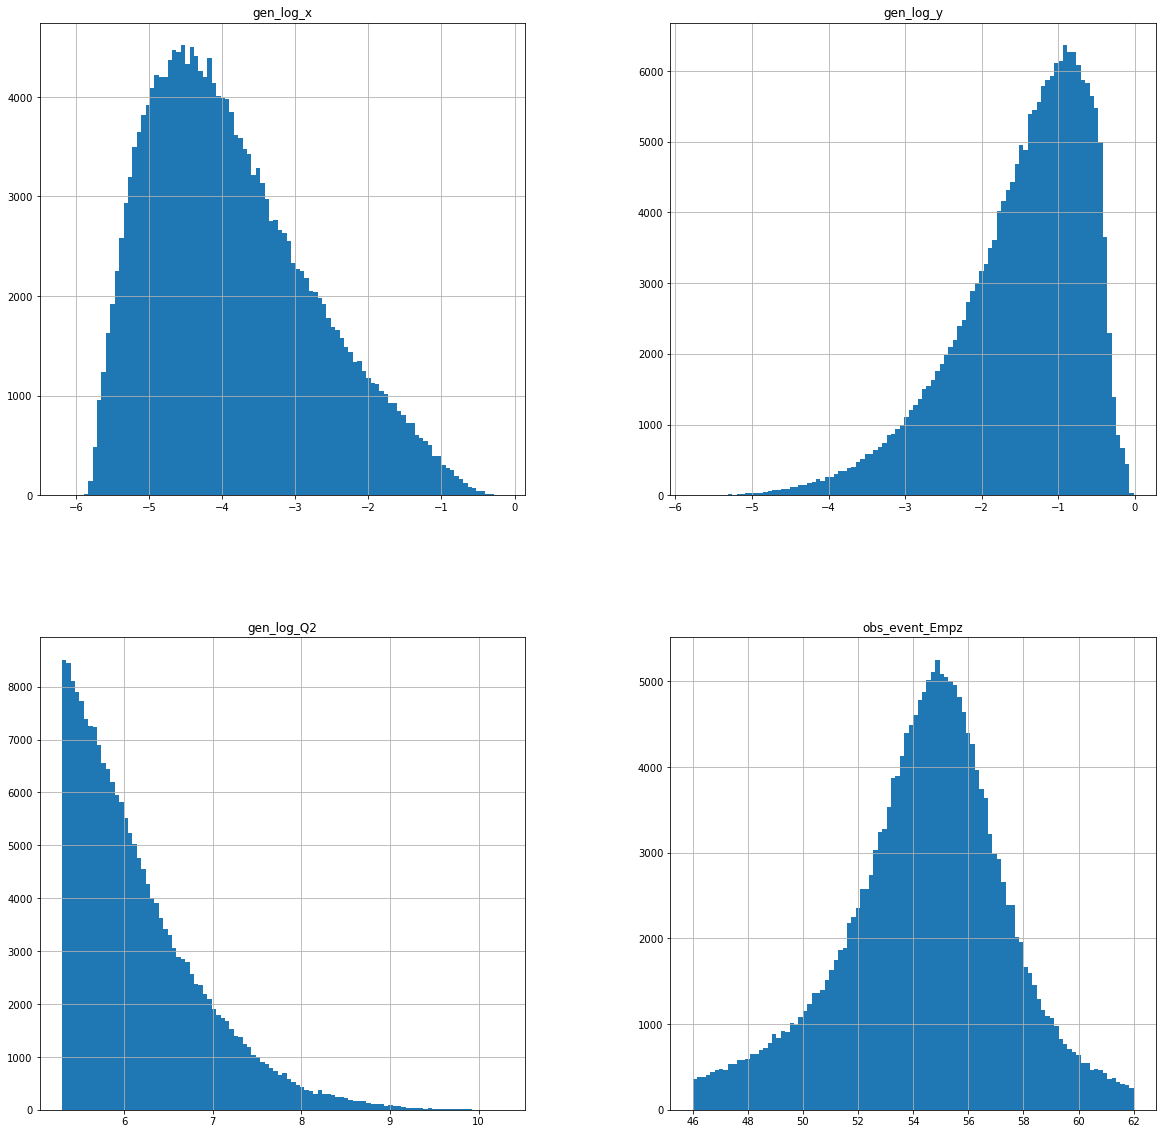

In [20]:
pandas_df.hist( figsize=(20,20), bins=100, column=[#'from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz', 
                        ])
#plt.show()

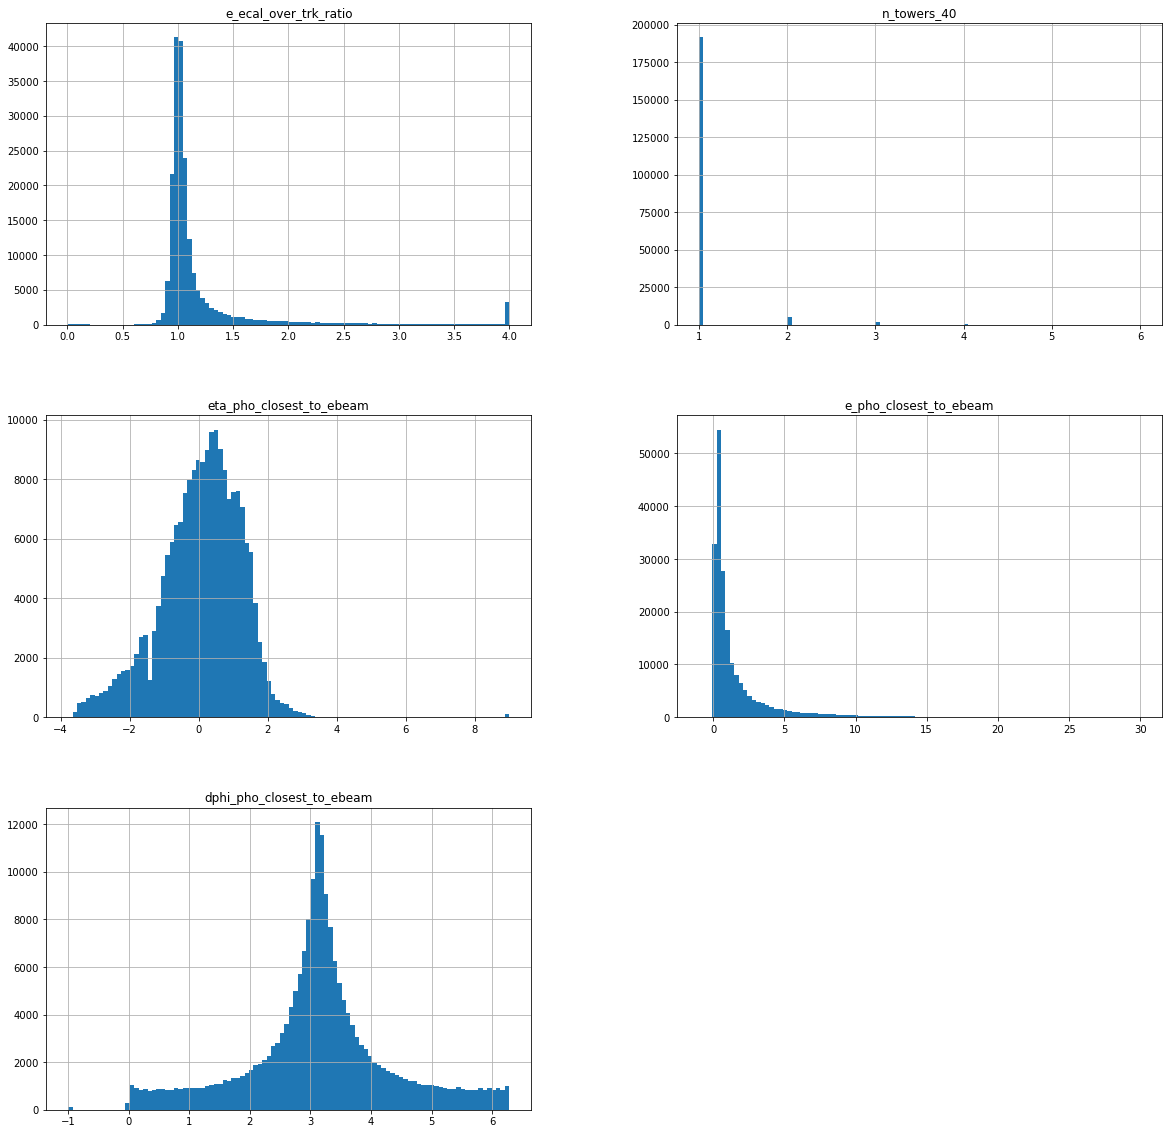

In [21]:

pandas_df.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


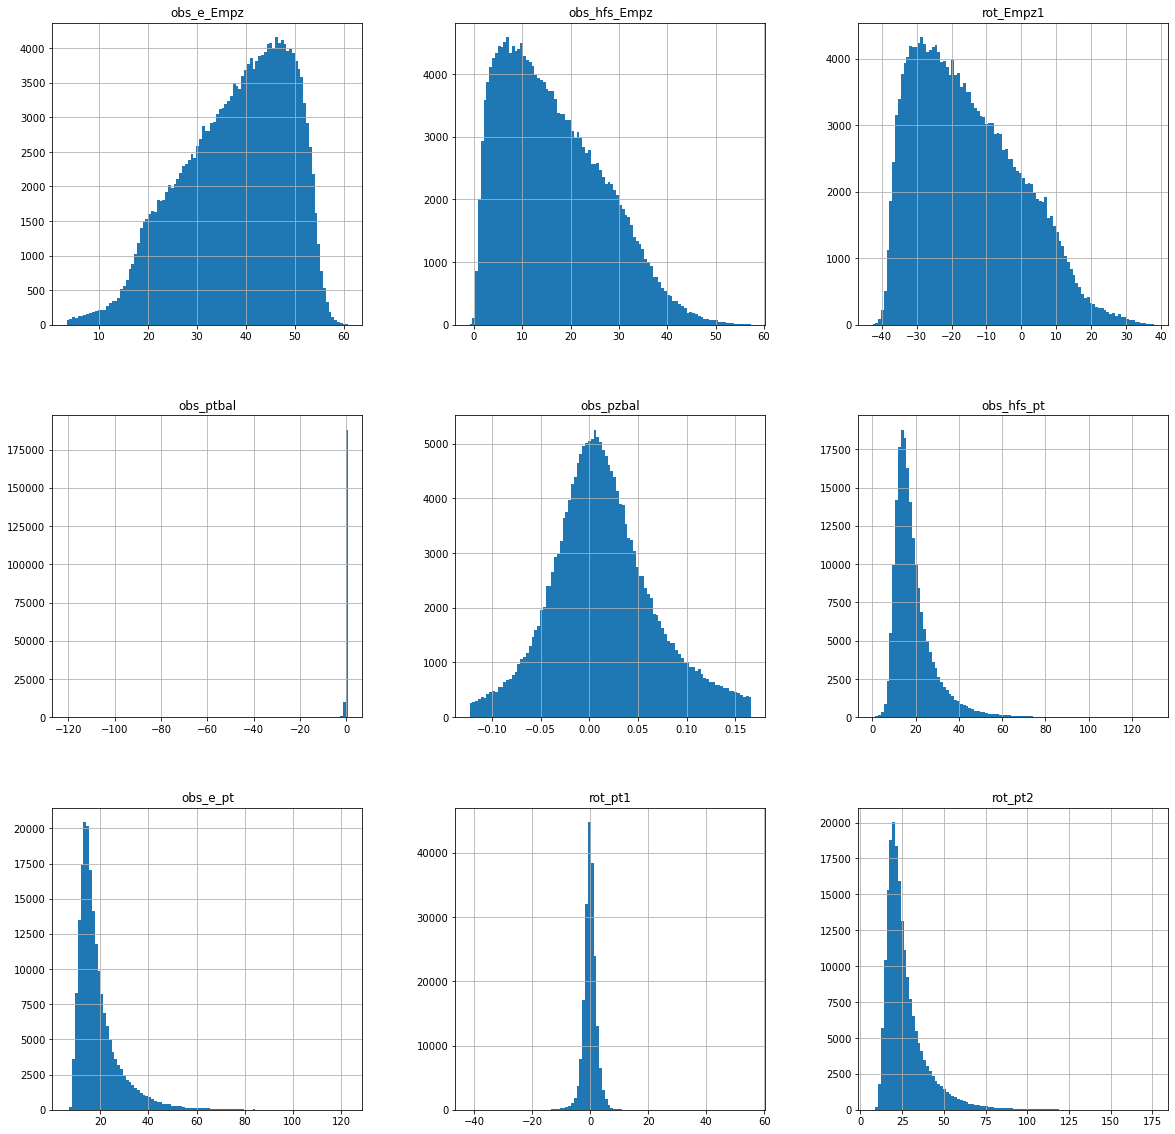

In [22]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [23]:
os.environ['CUDA_VISIBLE_DEVICES']="0"

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump


EarlyStopping_patience=6
batch_size_setval = 2048

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=EarlyStopping_patience,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
#    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['dphi_pho_closest_to_ebeam'].to_numpy(),
#    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
    pandas_df['obs_pzbal'].to_numpy(),
    pandas_df['obs_ptbal'].to_numpy(),
    pandas_df['obs_DeltaPhi'].to_numpy(),
    pandas_df['obs_kine_ys'].to_numpy(),

    pandas_df['obs_cHFSs_pt'].to_numpy(),
    pandas_df['obs_cHFSs_M'].to_numpy(),
    pandas_df['obs_cHFSs_theta'].to_numpy(),
    pandas_df['obs_cHFSs_phi'].to_numpy(),
    pandas_df['obs_cHFSs_N'].to_numpy(),
    pandas_df['obs_cHFSs_dRavg'].to_numpy(),
    
    pandas_df['obs_cHFSs_dR2avg'].to_numpy(),
    pandas_df['obs_cHFSs_Empz'].to_numpy(),
    pandas_df['obs_cHFSs_Eppz'].to_numpy(),
    pandas_df['obs_cHFSe_Empz'].to_numpy(),
    pandas_df['obs_cHFSe_Eppz'].to_numpy(), 
    pandas_df['obs_cHFSe_keE0'].to_numpy(),
    pandas_df['obs_cHFSs_keE0'].to_numpy(),
    pandas_df['obs_cHFSs_kesE0'].to_numpy(),

]


#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
    pandas_df['gen_tau1b'].to_numpy(),
]

    
GY = pandas_df['gen_kine_ys'].to_numpy()
GQ2 = pandas_df['gen_kine_Q2s'].to_numpy()
Gtau = pandas_df['gen_tau1b'].to_numpy()
Rtau = pandas_df['obs_tau1bs'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_name )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_name )

    
print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_name )
print('    %s-scalers/target_scaler.pkl' % training_name )

dump( scaler, open('%s-scalers/input_scaler.pkl' % training_name , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_name , 'wb'))


X_train, X_test,  Y_r_train, Y_r_test,    GY_train, GY_test,    GQ2_train, GQ2_test,    Gtau_train, Gtau_test,    Rtau_train, Rtau_test  = train_test_split( X, Y_r, GY,GQ2,Gtau,Rtau,  test_size=0.2)
    


  Dir training_h1_reg_v4b_tau1b_2-scalers already exists




 Saving the input and learning target scalers:

    training_h1_reg_v4b_tau1b_2-scalers/input_scaler.pkl
    training_h1_reg_v4b_tau1b_2-scalers/target_scaler.pkl


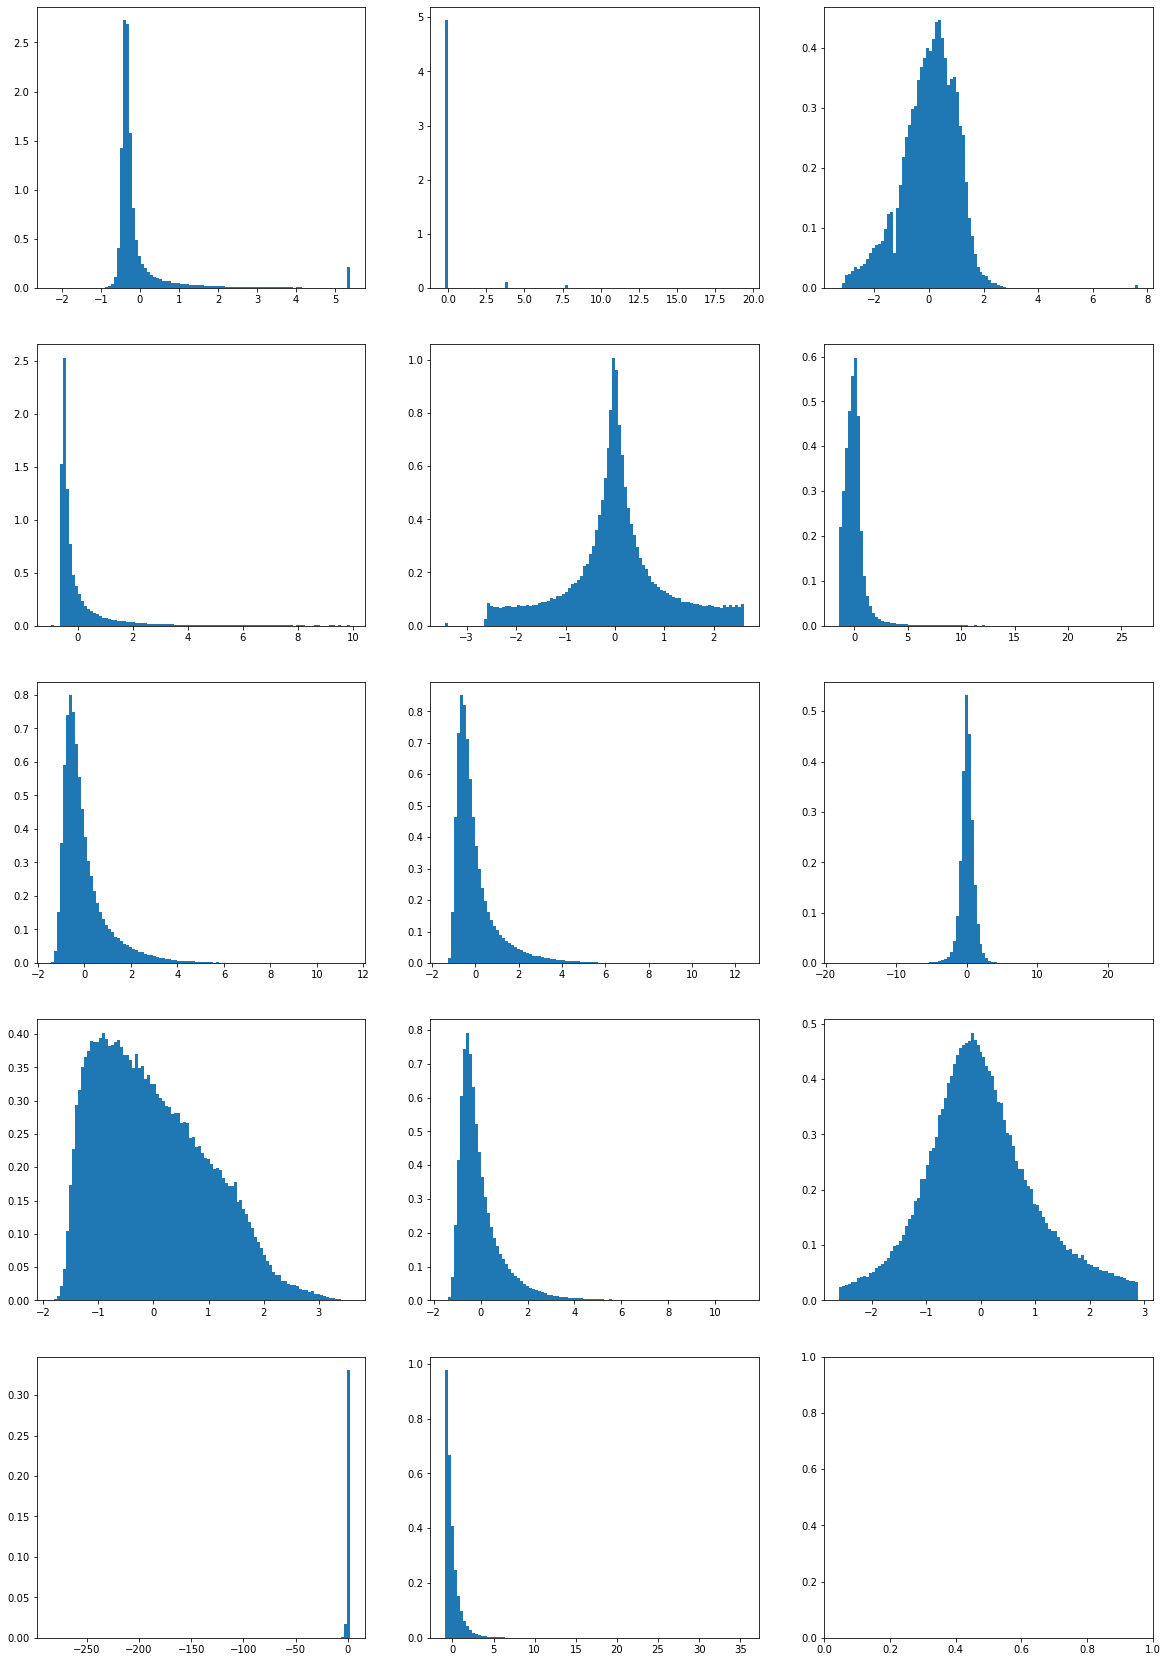

In [26]:
fig,ax = plt.subplots(5,3,figsize=(20,30))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )
ax[4][1].hist( X[:,13], density=True, bins=100 )




plt.show()

In [35]:
print(len(X[0]))
print(len(Y_r[0]))

29
4


## Set up the regression network

In [36]:
model_r = Sequential()

#-- initial layer
model_r.add(Dense(64, input_dim=len(X[0]), activation='relu'))
model_r.add(Dropout(dropout_setval))

#-- middle part
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(1024, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))

#-- final layers
model_r.add(Dense(64, activation='selu'))
model_r.add(Dense(len(Y_r[0]), activation='linear'))

opt_r = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval_reg, amsgrad=amsgrad_setval )
myloss_r = tf.keras.losses.Huber()

model_r.compile(loss=myloss_r, optimizer=opt_r, metrics=['accuracy'])

model_r.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [37]:
%%time

hist_r = model_r.fit(
    X_train, Y_r_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_r_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
78/78 [==============================] - 3s 8ms/step - loss: 0.2778 - accuracy: 0.6189 - val_loss: 0.1144 - val_accuracy: 0.7684
Epoch 2/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0969 - accuracy: 0.7919 - val_loss: 0.0848 - val_accuracy: 0.8080
Epoch 3/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0791 - accuracy: 0.8145 - val_loss: 0.0735 - val_accuracy: 0.8223
Epoch 4/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.8254 - val_loss: 0.0670 - val_accuracy: 0.8311
Epoch 5/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0652 - accuracy: 0.8328 - val_loss: 0.0624 - val_accuracy: 0.8355
Epoch 6/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.8371 - val_loss: 0.0590 - val_accuracy: 0.8400
Epoch 7/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0584 - accuracy: 0.8407 - val_loss: 0.0565 - val_accuracy: 0.8434
Epoch 

78/78 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.8824 - val_loss: 0.0328 - val_accuracy: 0.8811
Epoch 59/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.8828 - val_loss: 0.0326 - val_accuracy: 0.8817
Epoch 60/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.8833 - val_loss: 0.0324 - val_accuracy: 0.8816
Epoch 61/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.8835 - val_loss: 0.0324 - val_accuracy: 0.8813
Epoch 62/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.8839 - val_loss: 0.0323 - val_accuracy: 0.8831
Epoch 63/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0321 - accuracy: 0.8837 - val_loss: 0.0321 - val_accuracy: 0.8833
Epoch 64/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.8844 - val_loss: 0.0320 - val_accuracy: 0.8825
Epoch 65/5000

78/78 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.8936 - val_loss: 0.0280 - val_accuracy: 0.8926
Epoch 116/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.8932 - val_loss: 0.0280 - val_accuracy: 0.8927
Epoch 117/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.8940 - val_loss: 0.0279 - val_accuracy: 0.8920
Epoch 118/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.8943 - val_loss: 0.0279 - val_accuracy: 0.8928
Epoch 119/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.8940 - val_loss: 0.0278 - val_accuracy: 0.8925
Epoch 120/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 0.8941 - val_loss: 0.0278 - val_accuracy: 0.8924
Epoch 121/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.8943 - val_loss: 0.0277 - val_accuracy: 0.8928
Epoch 1

Epoch 172/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.8996 - val_loss: 0.0258 - val_accuracy: 0.8970
Epoch 173/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.8997 - val_loss: 0.0258 - val_accuracy: 0.8967
Epoch 174/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0248 - accuracy: 0.8994 - val_loss: 0.0257 - val_accuracy: 0.8966
Epoch 175/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.8996 - val_loss: 0.0257 - val_accuracy: 0.8966
Epoch 176/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.8994 - val_loss: 0.0257 - val_accuracy: 0.8972
Epoch 177/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0246 - accuracy: 0.8998 - val_loss: 0.0256 - val_accuracy: 0.8970
Epoch 178/5000
78/78 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.8993 - val_loss: 0.0256 - val_accuracy:

Epoch 229/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.9031 - val_loss: 0.0243 - val_accuracy: 0.9007
Epoch 230/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.9032 - val_loss: 0.0243 - val_accuracy: 0.9006
Epoch 231/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.9033 - val_loss: 0.0244 - val_accuracy: 0.9004
Epoch 232/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0230 - accuracy: 0.9033 - val_loss: 0.0243 - val_accuracy: 0.9003
Epoch 233/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.9034 - val_loss: 0.0243 - val_accuracy: 0.9004
Epoch 234/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0230 - accuracy: 0.9034 - val_loss: 0.0243 - val_accuracy: 0.9003
Epoch 235/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0229 - accuracy: 0.9032 - val_loss: 0.0243 - val_accuracy:

Epoch 286/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9061 - val_loss: 0.0235 - val_accuracy: 0.9021
Epoch 287/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9059 - val_loss: 0.0234 - val_accuracy: 0.9026
Epoch 288/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9059 - val_loss: 0.0234 - val_accuracy: 0.9024
Epoch 289/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9060 - val_loss: 0.0236 - val_accuracy: 0.9021
Epoch 290/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0218 - accuracy: 0.9059 - val_loss: 0.0233 - val_accuracy: 0.9031
Epoch 291/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0218 - accuracy: 0.9063 - val_loss: 0.0233 - val_accuracy: 0.9026
Epoch 292/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0218 - accuracy: 0.9063 - val_loss: 0.0233 - val_accuracy:

Epoch 343/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0210 - accuracy: 0.9082 - val_loss: 0.0227 - val_accuracy: 0.9041
Epoch 344/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9082 - val_loss: 0.0227 - val_accuracy: 0.9039
Epoch 345/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9085 - val_loss: 0.0227 - val_accuracy: 0.9054
Epoch 346/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9084 - val_loss: 0.0227 - val_accuracy: 0.9037
Epoch 347/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9086 - val_loss: 0.0228 - val_accuracy: 0.9050
Epoch 348/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9084 - val_loss: 0.0227 - val_accuracy: 0.9055
Epoch 349/5000
78/78 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9084 - val_loss: 0.0226 - val_accuracy:

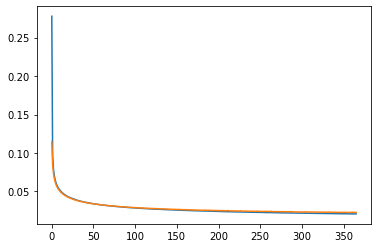

In [38]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])

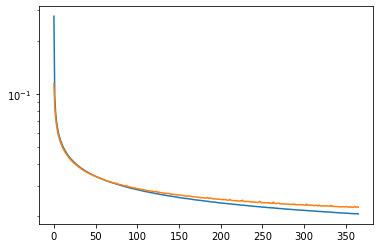

In [39]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])
plt.yscale('log')

In [40]:
tf.keras.models.save_model(model_r, '%s_regression' % training_name )

INFO:tensorflow:Assets written to: training_h1_reg_v4b_tau1b_2_regression/assets


In [41]:
mypreds_r = model_r.predict(X_test,batch_size=1000)

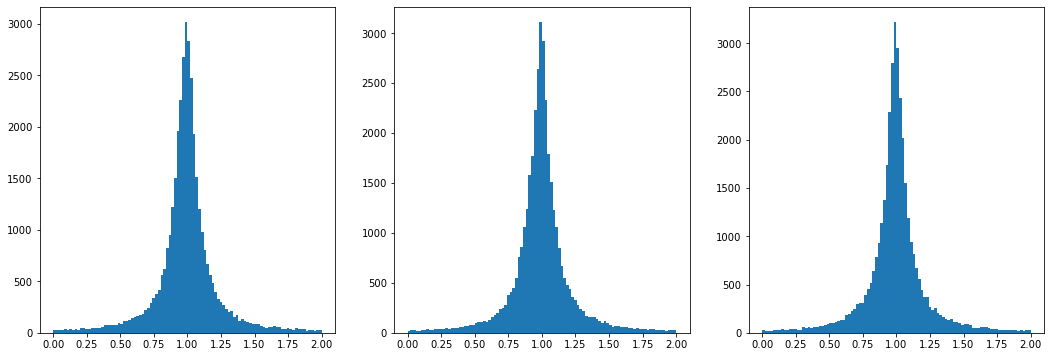

In [42]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

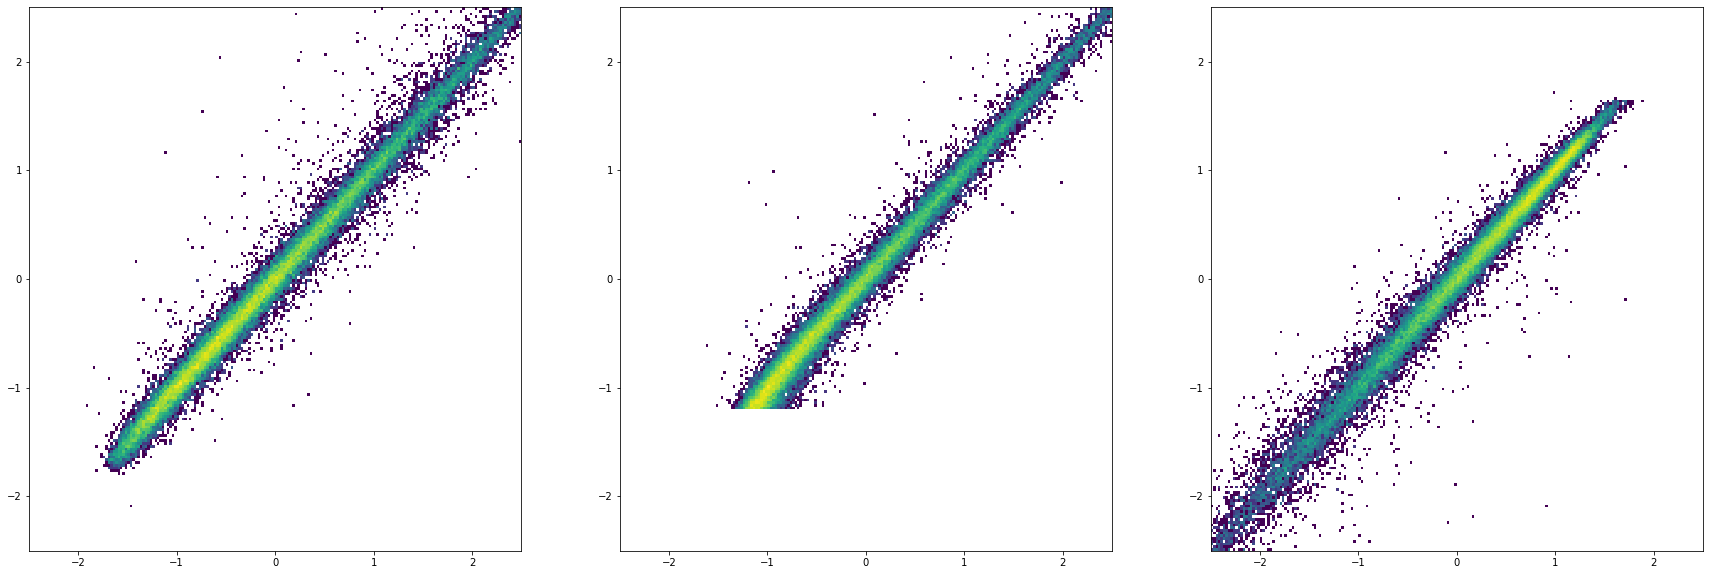

In [43]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [44]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

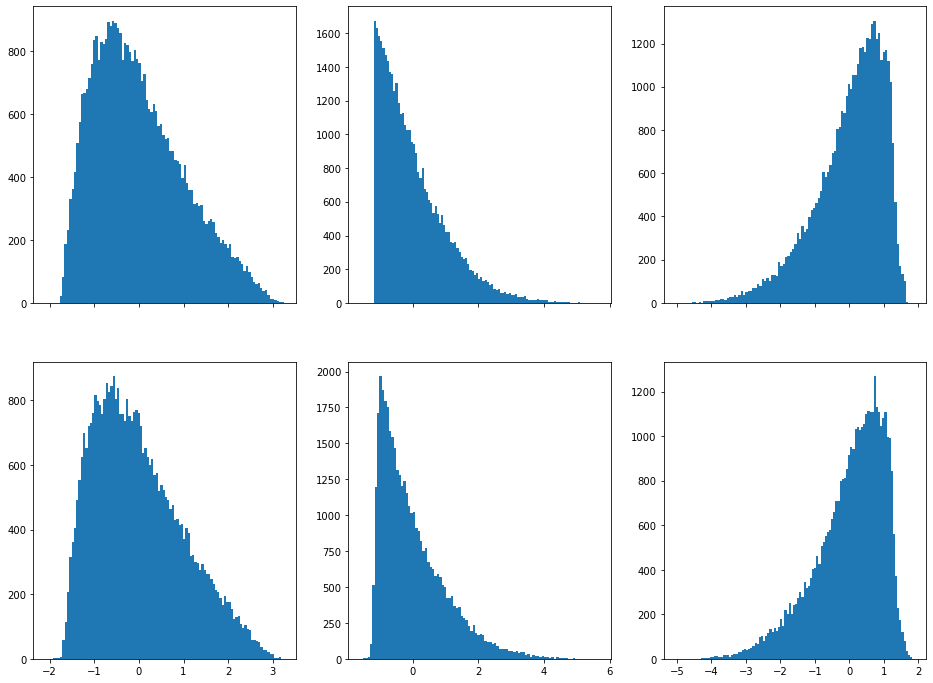

In [45]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

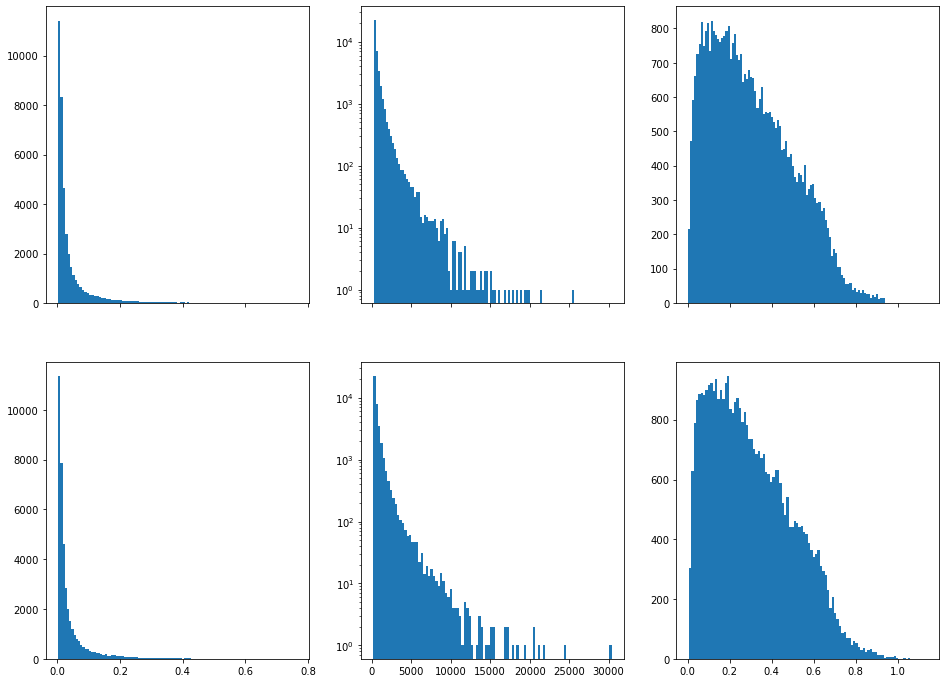

In [46]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

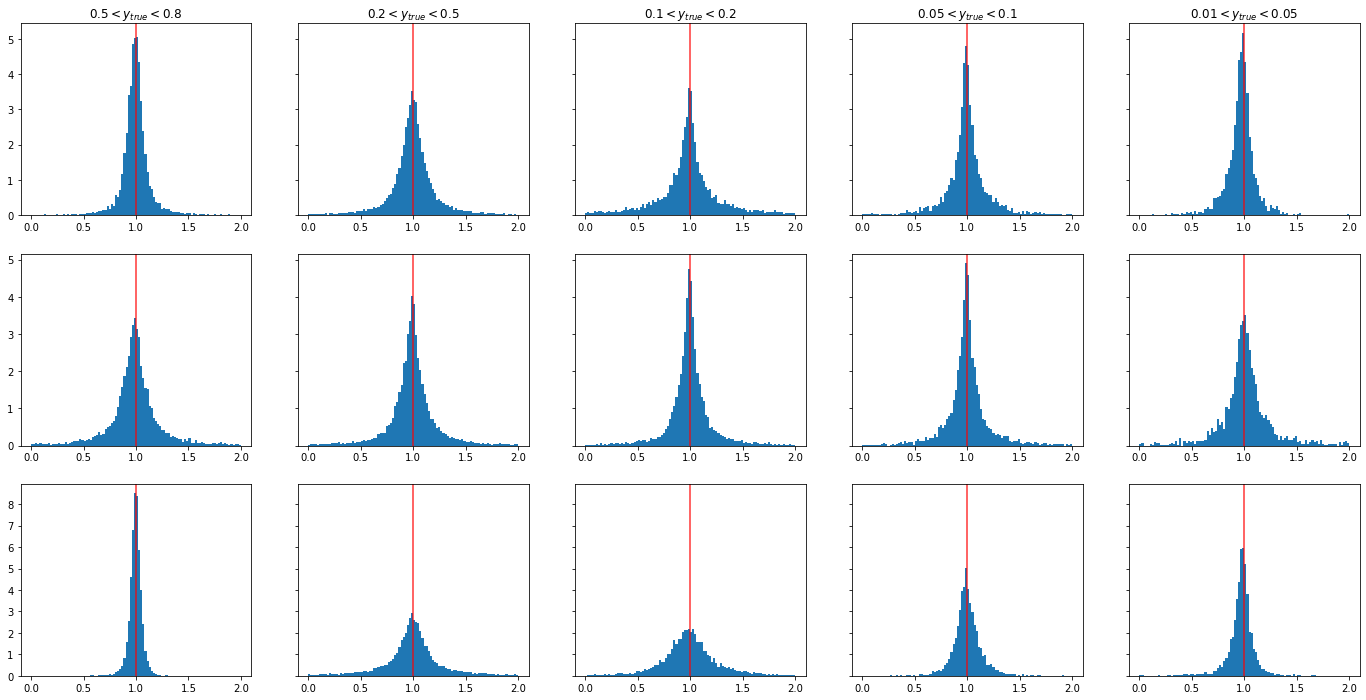

In [47]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


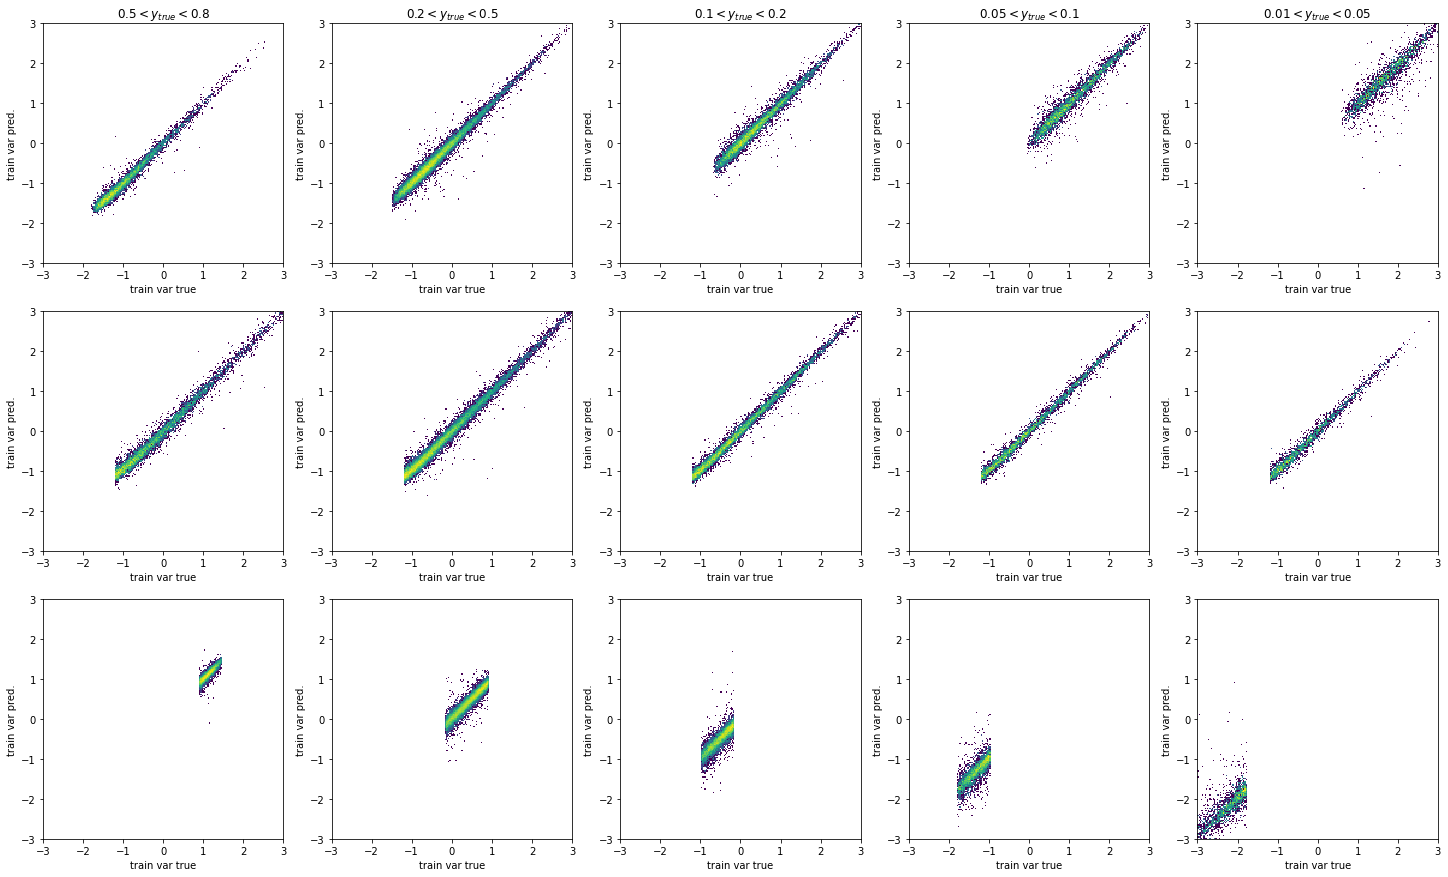

In [48]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

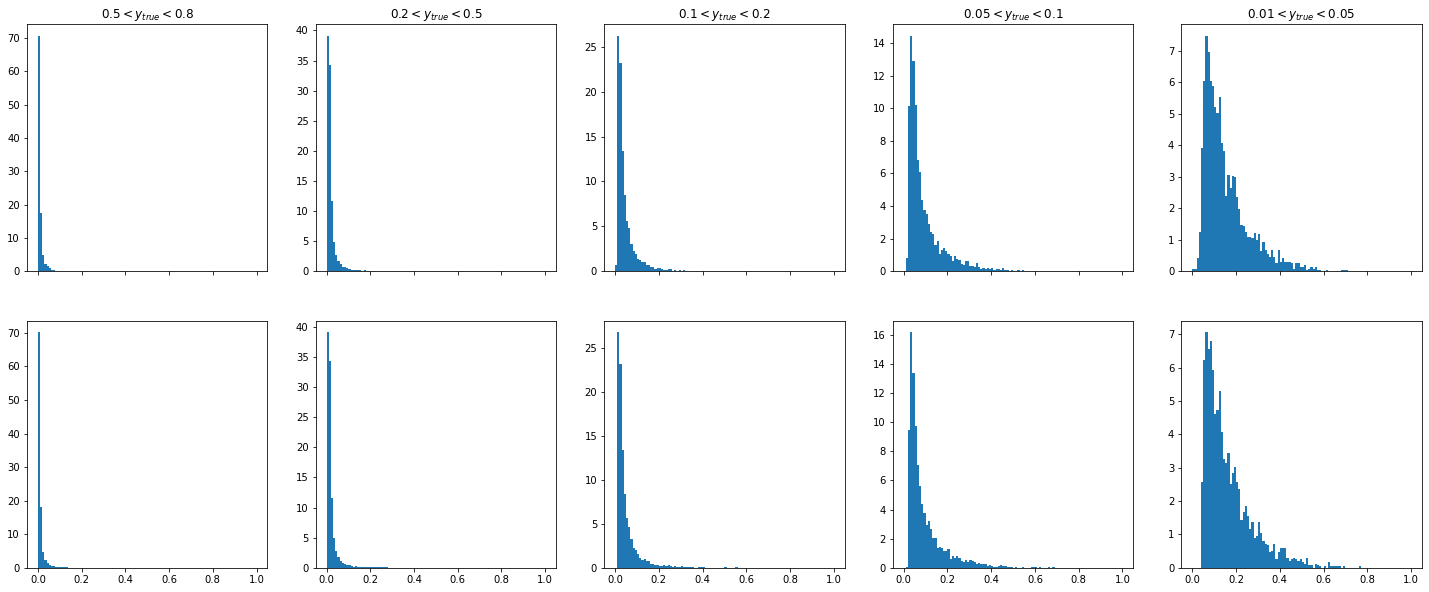

In [49]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

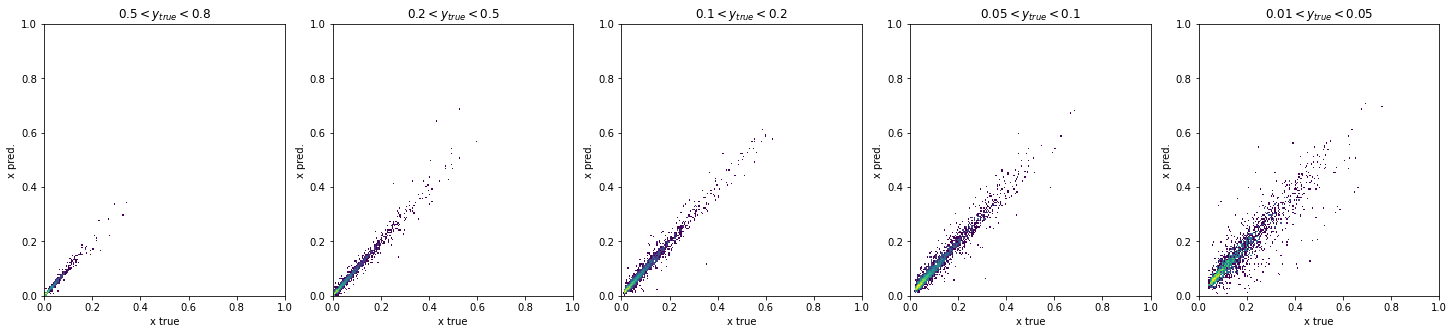

In [50]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

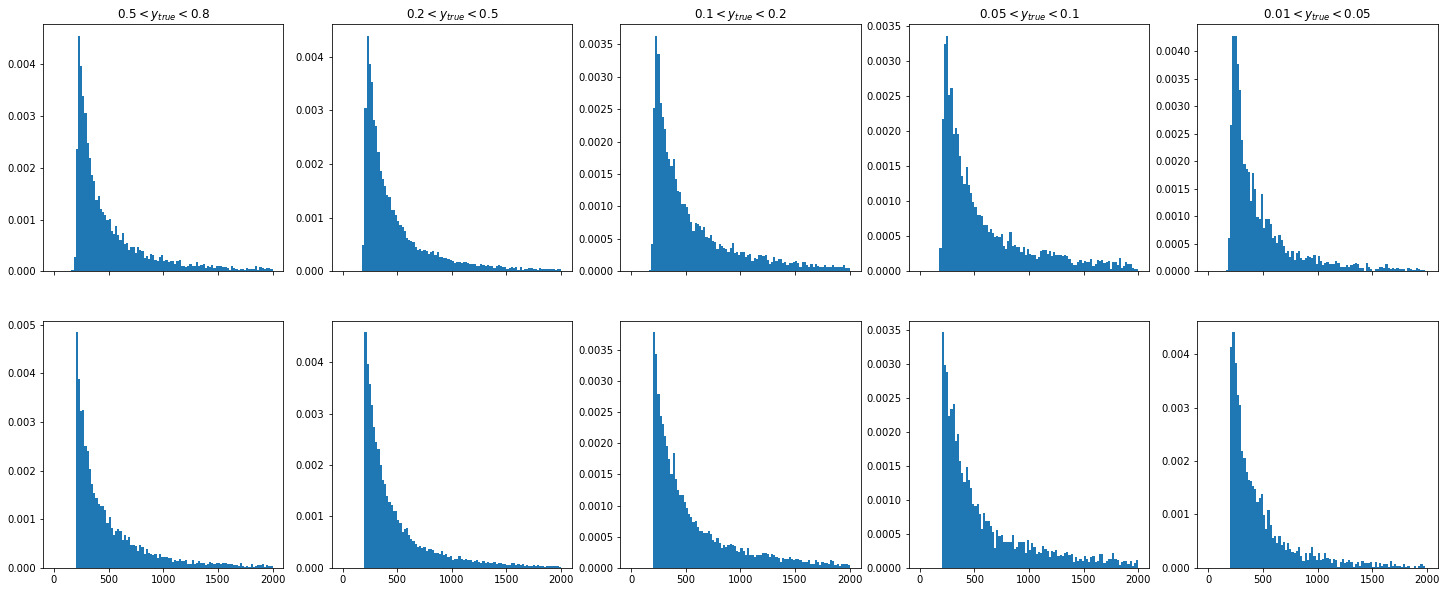

In [51]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

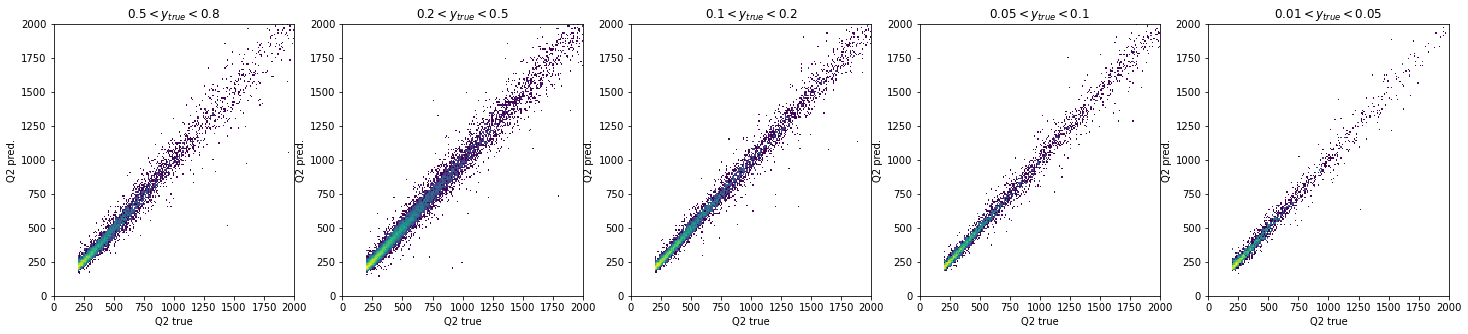

In [52]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

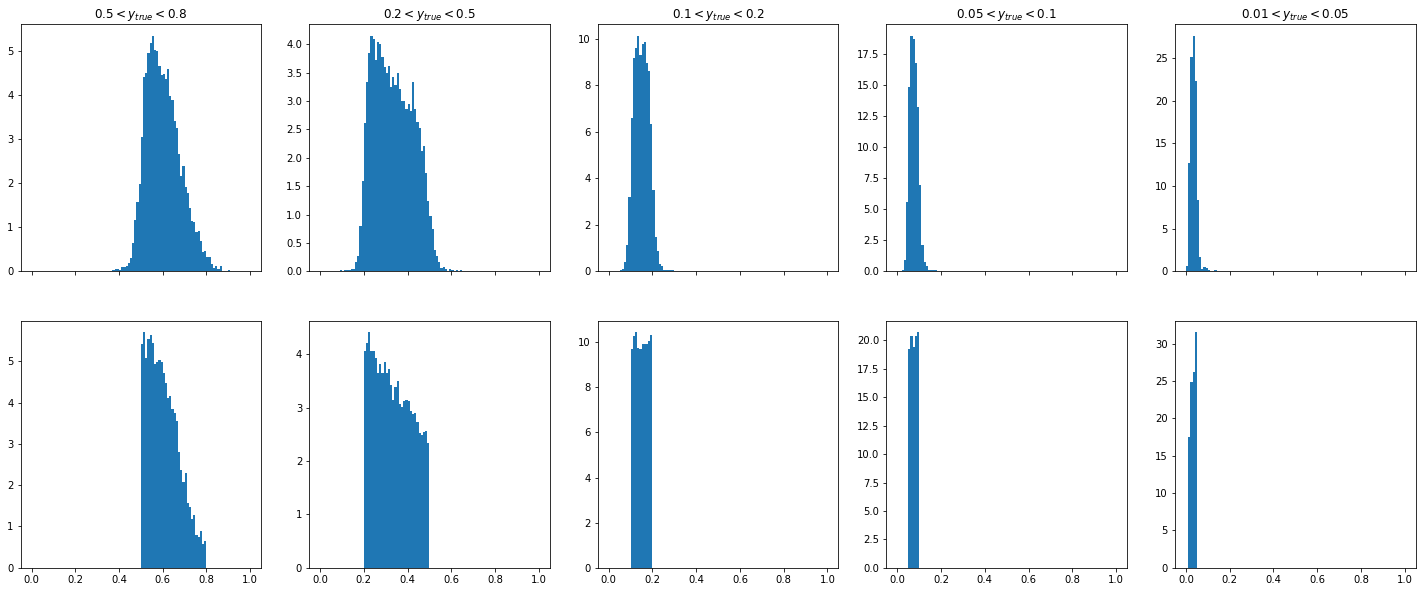

In [53]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

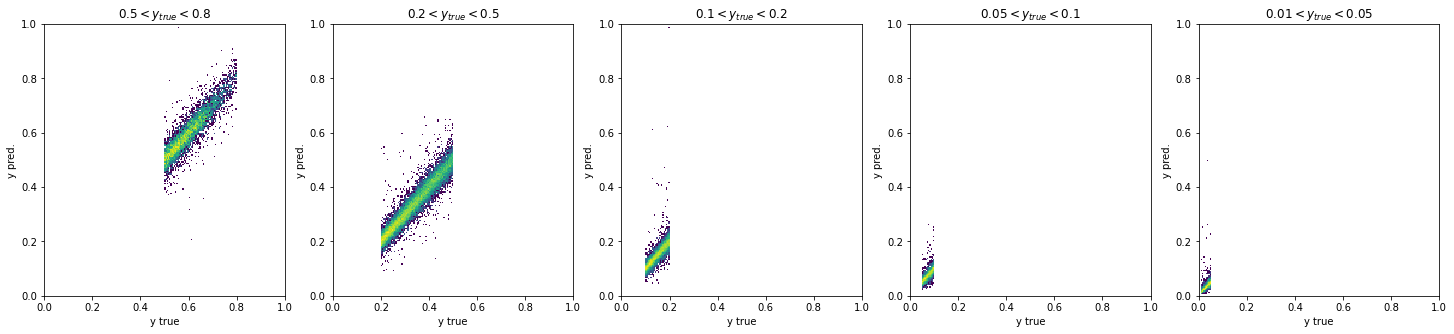

In [54]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

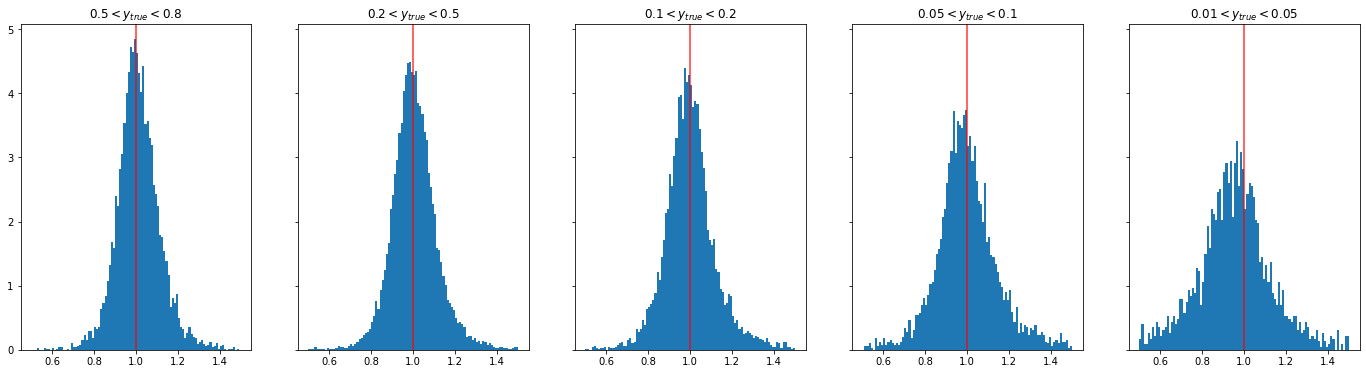

In [55]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

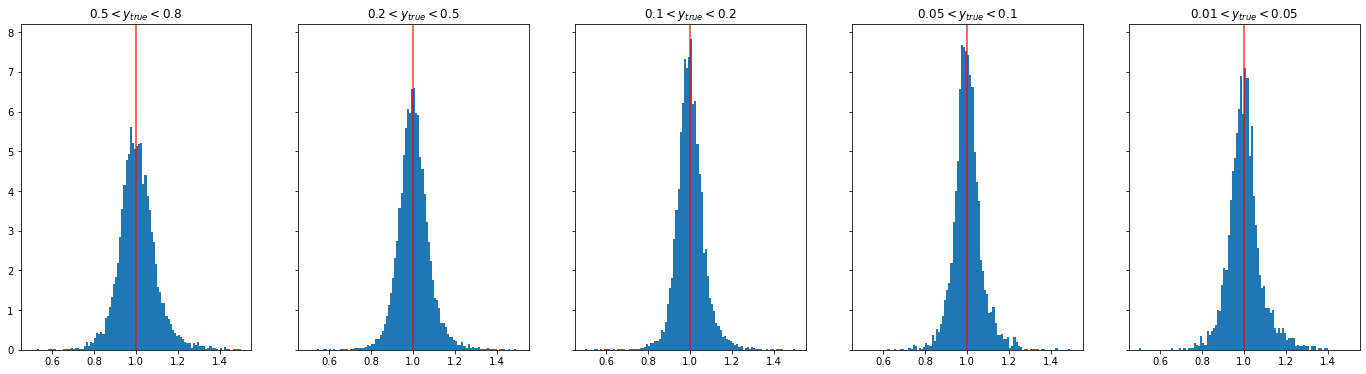

In [56]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

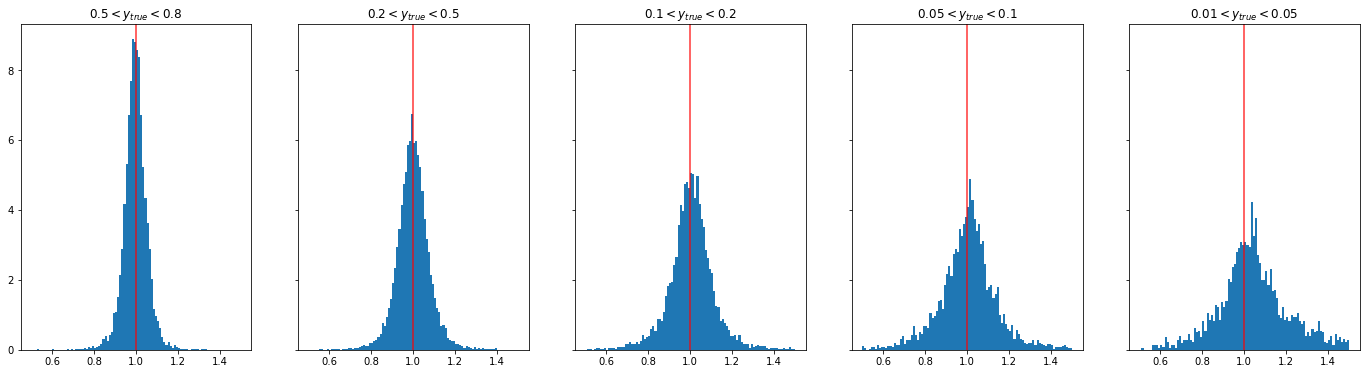

In [57]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80


KeyError: 'obs_kine_xis'

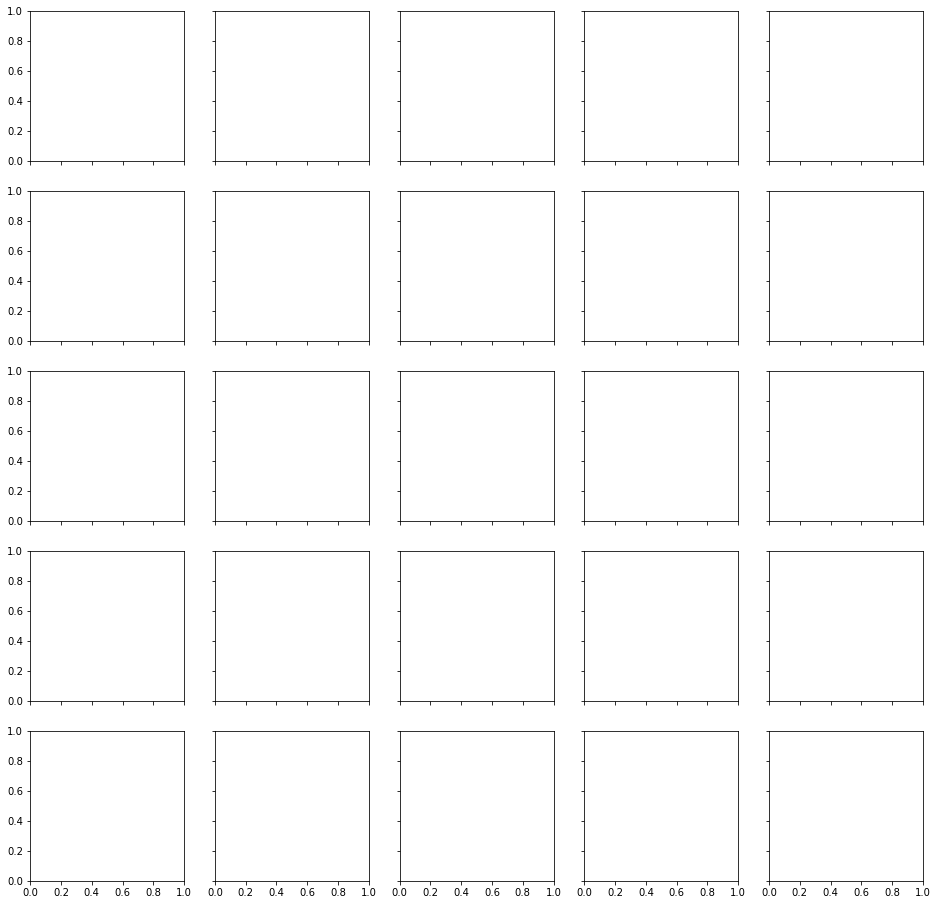

In [61]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.0
xmax = 2.0

#xmin = 0.5
#xmax = 1.5

y_cut = [
    'gen_kine_ys>0.50 and gen_kine_ys<0.80',
    'gen_kine_ys>0.20 and gen_kine_ys<0.50',
    'gen_kine_ys>0.10 and gen_kine_ys<0.20',
    'gen_kine_ys>0.05 and gen_kine_ys<0.10',
    'gen_kine_ys>0.01 and gen_kine_ys<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_xis']/pandas_df.query(y_cut[yi])['gen_kine_xis'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)


## resolution in Q2

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  0,  5 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  0,  5 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  0,  5 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  0,  5 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  1,  4 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  1,  4 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  1,  4 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  1,  4 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  1,  4 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  2,  3 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  2,  3 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  2,  3 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  2,  3 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  2,  3 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  3,  0 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  3,  0 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  3,  0 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  3,  0 : gen_kine_ys>0.05 and gen_kine_y

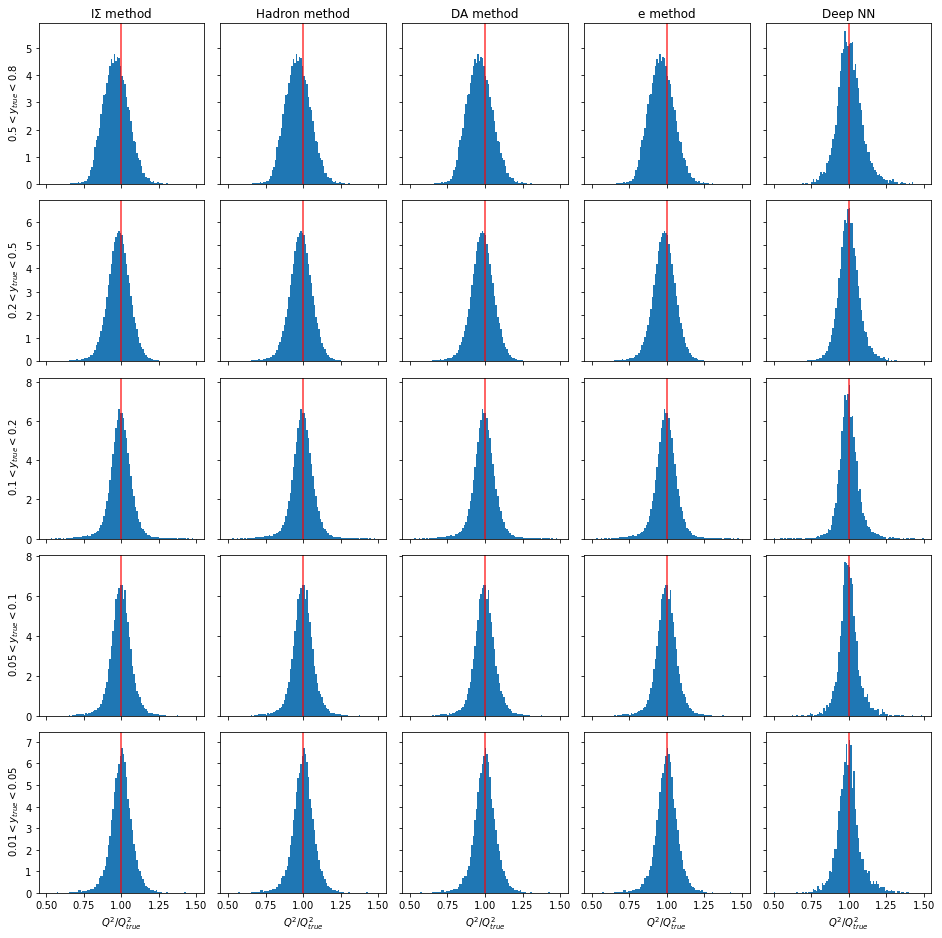

In [62]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

#y_cut = ....

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_Q2s' ]/pandas_df.query(y_cut[yi])['gen_kine_Q2s'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Resolution in y

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  0,  5 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  0,  5 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  0,  5 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  0,  5 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  1,  4 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  1,  4 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  1,  4 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  1,  4 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  1,  4 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  2,  3 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  2,  3 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  2,  3 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  2,  3 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  2,  3 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  3,  0 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  3,  0 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  3,  0 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  3,  0 : gen_kine_ys>0.05 and gen_kine_y

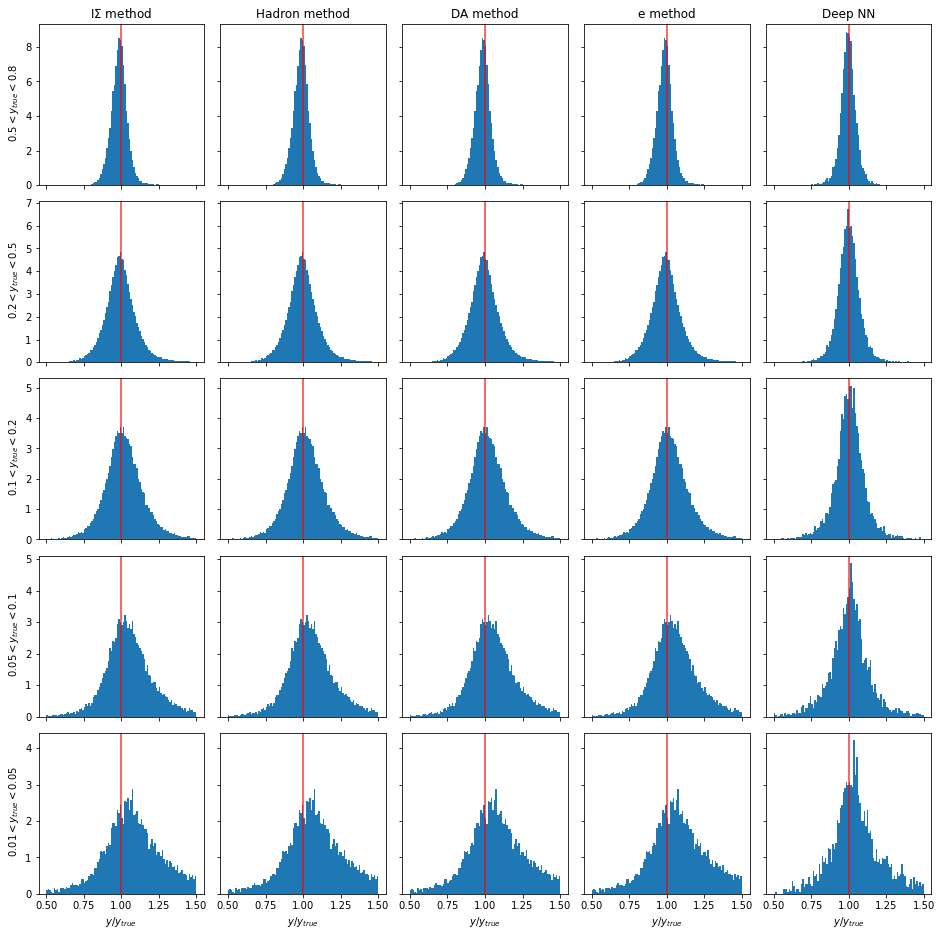

In [63]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

#y_cut = ..

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_ys' ]/pandas_df.query(y_cut[yi])['gen_kine_ys'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)